<a href="https://colab.research.google.com/github/sacamiso/AjedrezDistribuidos/blob/main/Entregable3_parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En primer lugar actualizo la librería FastAI y descargo la librería de datasets de HuggingFace. Una vez hecho esto, he reiniciado el kernel. 

In [1]:
!pip install fastai -Uqq
!pip install datasets -Uqq

Lo siguiente es cargar las librerías necesarias para la realización de este entregable.

In [2]:
import pandas as pd
from fastai.text.all import *
from datasets import load_dataset

**DATASET**                                                                     
Para mi entregable he decidido usar el dataset yahoo_answers_topics, es un dataset que su objetivo es detectar el tópico al que pertenece una respuesta de yahoo.

Y descargo el dataset usando el siguiente comando.

In [3]:
yahoo_answers_topics_dataset = load_dataset("yahoo_answers_topics")

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

El siguiente paso es:

**LA CARGA DE DATOS**

Cargo el dataset en distintos dataframes de pandas

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_df = yahoo_answers_topics_dataset["train"].to_pandas()
test_df = yahoo_answers_topics_dataset["test"].to_pandas()

Como este dataset no tiene un conjunto de validación diferenciado, lo tengo que crear yo de la siguiente manera

In [6]:
train_df, valid_df  = train_test_split(train_df, test_size=0.2, random_state=42)

Lo siguiente es procesar el dataset para tenerlo en el formato adecuado

In [7]:
train_df['set']=False
valid_df['set']=True
train_df = train_df.drop(columns=['id'],axis=1)
valid_df = valid_df.drop(columns=['id'],axis=1)
train_valid_df = pd.concat([train_df[0:10000],valid_df[0:2000]]) 
train_valid_df = train_valid_df.rename(columns={"question_content": "text"})

**MODELO DE LENGUAJE**

El siguiente paso es crear un DataBlock a oartir del dataframe

In [8]:
db_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True,max_vocab=100000), # Indic0 que voy a trabajar con un modelo de lenguaje
    get_items=ColReader('text'), # Indico donde estará el texto dentro del dataframe
    splitter=RandomSplitter(0.1) # Parto el dataset en entrenamiento y validación
)

El siguiente paso es crear el dataloader

In [9]:
dls_lm = db_lm.dataloaders(train_valid_df, bs=128, seq_len=80)

Voy a mostrar un batch de este dataloader.  Como se puede apreciar, la entrada del modelo es una frase, y la salida es dicha frase desplazada una posición a la derecha.

In [10]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj where is a good website for free music like hip hop , pop , r&b , rap , not xxunk , xxunk , country , thats lame xxbos xxbos xxbos xxbos xxbos i am a little over xxunk but am very active . i have long blond hair and xxunk eyes . i have a great time outdoors and go hunting and fishing every chance i get . i love to ride horse and am probably the xxunk","xxmaj where is a good website for free music like hip hop , pop , r&b , rap , not xxunk , xxunk , country , thats lame xxbos xxbos xxbos xxbos xxbos i am a little over xxunk but am very active . i have long blond hair and xxunk eyes . i have a great time outdoors and go hunting and fishing every chance i get . i love to ride horse and am probably the xxunk when"
1,enable me to understand a social phenomenon of people xxunk out of answering urgent phone calls in meetings . \n\n xxmaj it is only natural to expect the person who is supposed to answer the call to make an exception to the rule if they are the only ones that can help and you have no time to wait . \n\n xxmaj can you read this and then tell me what you think ? \n xxmaj can you offer me,me to understand a social phenomenon of people xxunk out of answering urgent phone calls in meetings . \n\n xxmaj it is only natural to expect the person who is supposed to answer the call to make an exception to the rule if they are the only ones that can help and you have no time to wait . \n\n xxmaj can you read this and then tell me what you think ? \n xxmaj can you offer me some


Creo el Learner

In [11]:
learn = language_model_learner(
    dls_lm, # El dataloader que usamos
    AWD_LSTM, # La arquitectura que es la misma usada en la práctica anterior
    drop_mult=0.3, # Aplicamos dropout para evitar el sobreajuste
    metrics=[accuracy, Perplexity()] # Como métricas usamos la accuracy y la perplexity.
).to_fp16()

Por último entreno el modelo

In [12]:
learn.fine_tune(10,base_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.701232,4.038553,0.243222,56.744160,00:32


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.940749,3.881855,0.262209,48.514137,00:28
1,3.840601,3.818787,0.266952,45.548927,00:28
2,3.724099,3.812310,0.268577,45.254868,00:26
3,3.554670,3.835071,0.263918,46.296707,00:30
4,3.372798,3.887241,0.264280,48.776146,00:26
5,3.176752,3.955364,0.259047,52.214710,00:26
6,2.977034,4.024759,0.256654,55.966835,00:26
7,2.804019,4.082109,0.255400,59.270336,00:26
8,2.660426,4.110284,0.254315,60.964020,00:30
9,2.563170,4.117759,0.254492,61.421429,00:27


Una vez lo he entrenado, guardo el encoder que usaré luego para mi modelo de clasificación.

In [13]:
learn.save_encoder('finetuned')

**ENTRENADO UN MODELO DE CLASIFICACIÓN**

Ahora voy a crear mi modelo de clasificación de texto, los pasos vana a ser similares a los vistos para la creación de un modelo de clasificación de imágenes. Comienzo definiendo un DataBlock que se creará a partir de nuestro dataframe df.

In [25]:
topic_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab), # La entrada del modelo es texto usando el mismo 
                                                           # vocabulario que en el modelo de lenguaje 
            CategoryBlock), #, y la salida una clase 
    get_x=ColReader('text'),  # Indico donde estará el texto dentro del dataframe
    get_y=ColReader('topic'), # Indico cómo extraer la clase del dataframe
    splitter=ColSplitter('set') # Parto el dataset en entrenamiento y validación
)

Lo siguiente es definir el dataloader a partir del DataBlock que acabo de crear.

In [26]:
dls = topic_clas.dataloaders(train_valid_df, bs=64)

Puedo mostrar un batch del dataloader.

In [27]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos xxup xxunk xxup and xxup religion xxup of xxup xxunk xxup of xxup xxunk \n 1 . xxmaj everything was subject to his xxunk power . \n 2 . xxmaj he xxunk many xxunk xxunk . \n 3 . xxmaj he xxunk sight to the blind . \n 4 . xxmaj he cast out xxunk , which sometimes "" cut up "" like those of xxmaj christ . \n 5 . xxmaj he xxunk the lame to walk . \n 6 . xxmaj he re - animated the dead . \n 7 . xxmaj he could read the thoughts of xxunk . \n 8 . xxmaj sometimes disappeared in a xxunk xxunk . \n 9 . xxmaj caused a tree to xxunk , while xxmaj christ made another tree to xxunk away . \n 10 . xxmaj the laws of nature xxunk him . \n 11 . xxmaj could",0
1,"xxbos i know xxmaj united xxmaj states of xxmaj america ( usa ) is the land of white americans and this is their land now whom they get from native americans before , just like many countries the land were xxunk and xxunk by people who are xxunk and developed the countries and teach people how to developed the country . i give credit to those people who are intelligent , wise , and xxunk because they use xxmaj god 's given xxunk not only for themselves but for all . xxmaj if xxunk people still xxunk the land we have no roads , buildings , and perhaps we are still living in forest like mostly xxmaj africa not fully developed and still there are many xxunk people and still no food and clothes to wear . xxmaj but because white are naturally intelligent people and xxmaj god chosen people",8


Paso ahora a crear el learner usando el método text_classifier_learner al que paso como arquitectura de red la arquitectura AWD_LSTM, además aplico dropout a nuestro modelo.

In [28]:
callbacks = [ShowGraphCallback(),
             SaveModelCallback()]

learnClass = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy,cbs=callbacks).to_fp16()

Cargo el encoder del modelo de lenguaje

In [29]:
learnClass = learnClass.load_encoder('finetuned')

Ahora puedo aplicar fine tuning al modelo.

epoch,train_loss,valid_loss,accuracy,time
0,2.098740,2.286514,0.293000,00:18


Better model found at epoch 0 with valid_loss value: 2.2865138053894043.


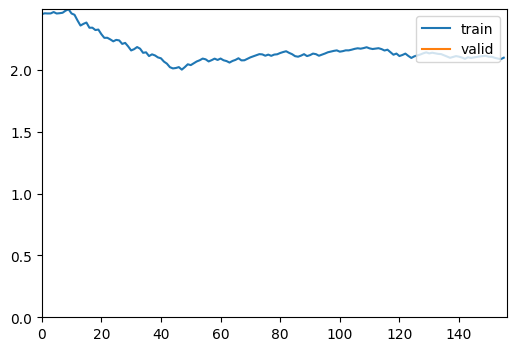

epoch,train_loss,valid_loss,accuracy,time
0,1.932352,2.032871,0.313500,00:16
1,1.867539,2.072267,0.293000,00:16
2,1.828526,1.969005,0.315000,00:18
3,1.837562,2.037786,0.306500,00:17
4,1.561393,2.093095,0.321500,00:16
5,1.326820,2.076671,0.336500,00:18
6,1.276595,2.093810,0.321500,00:16
7,1.219661,2.114015,0.345500,00:16
8,1.175012,2.077595,0.339500,00:17
9,1.109144,2.112191,0.340000,00:16


Better model found at epoch 0 with valid_loss value: 2.0328712463378906.


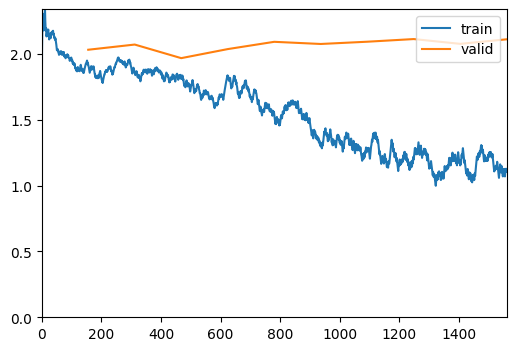

Better model found at epoch 2 with valid_loss value: 1.9690054655075073.


In [30]:
learnClass.fine_tune(10, 6e-2)

Ahora puedo usar el modelo para predecir el modelo de una frase nueva

In [32]:
learnClass.predict('with pale blue berries. in these peaceful shades--.')

('1',
 tensor(1),
 tensor([0.0590, 0.4441, 0.0327, 0.3032, 0.0409, 0.0241, 0.0517, 0.0162, 0.0082,
         0.0199]))

Por último, puedo validar mi modelo en el conjunto de test, para lo cuál hay que combinar los dataframes y construir un nuevo dataloader.

In [36]:
test_df['set']=True
test_df = test_df.drop(columns=['id'],axis=1)
train_test_df = pd.concat([train_df,test_df])
train_test_df = train_test_df.rename(columns={"question_content ": "text"})
dls_test = topic_clas.dataloaders(train_test_df, bs=64)

KeyError: ignored

Modifico ahora el dataloader de nuestro learner y procedo a validar

In [ ]:
learnClass.dls = dls_test
learnClass.validate()